# Projekt - Etap 1 - IUM 2021L
*// Konrad Bratosiewicz // Mateusz Chruściel //* 

# Zadanie 1
“Niektórzy klienci nie mogą zdecydować się na zakup oglądając produkt na stronie – ale pewnie gdybyśmy wiedzieli, które to są osoby, to odpowiednia zniżka  skłoniłaby ich do zakupu."

## Definicja problemu biznesowego
Proponowanie zniżki na zakup produktów na podstawie historii przeglądania produktu przez użytkownika.
## Zadania modelowania
Ocena szans na zakup produktu przez klienta - regresja. Na tej podstawie znalezienie najmniejszej zniżki, dla której prawdopodobieństwo zakupu produktu jest powyżej określonego poziomu.
## Założenia
+ Pierwsze wejście na stronę danego produktu nie powinno być nagradzane żadną zniżką
+ Wprowadzenie kary za zbyt duże zniżki, system musi minimalizować dawane zniżki
+ Model poprawnie klasyfikuje co najmniej 57% przypadków testowych
## Kryteria sukcesu

### Biznesowe
+ System proponuje średnio niższe zniżki przy tej samej skuteczności co naiwne rozwiązanie oferowania każdemu klientowi 20% zniżki

### Analityczne
+ Średnia zniżka dla naszego modelu < 20%
+ liczba kupionych przedmiotów używając naszego modelu ~= liczba kupionych przedmiotów przy 20% zniżce


# Analiza danych

Analiza danych składała się z 3 etapów. Analiza pierwszej dostarczonej próbki wymusiła opracowanie metod korekty, transformacji danych do czytelniejszej postaci oraz ich prezentacji. Po spreparowaniu zbioru danych okazało się, że dostarczone dane były niewystarczające - nie istniała zależność pomiędzy oferowaną zniżką a zakupem produktu. Po otrzymaniu nowego zestawu danych dokonaliśmy analogicznych przekształceń. Dalsza analiza wykazała, że otrzymana próbka była niereprezentatywna - w zbiorze nieobecne były przypadki zakupów produktów nieposiadających zniżki. Uczenie modelu na takich danych spowodowałoby, że wyliczonym warunkiem zakupu produktu byłoby obligatoryjne danie zniżki, co jest rozwiązaniem subobtymalnym. Z tego powodu ponownie poprosiliśmy o nowy zestaw danych, którego przeształcenia i analizę przedstawiamy poniżej.

### Wykorzystywane zbiory danych
Po analizie zawartości otrzymanych próbek uznaliśmy, że do naszych celów wykorzystamy dane zawarte w pliku sessions.jsonl. Pozostałe pliki nie zawierają atrybutów przydatnych do rozwiązania problemu.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
import numpy as np

data_folder_name = "data3"

data = pd.read_json(os.path.abspath('')+'/' + data_folder_name +"/sessions.jsonl", lines=True)
data = data[['session_id','timestamp','user_id','product_id','event_type','offered_discount','purchase_id']]

cleanup = {"event_type":{"BUY_PRODUCT":1, "VIEW_PRODUCT":-1}}
data = data.replace(cleanup)

valuable_data = ['timestamp','user_id', 'product_id', 'offered_discount', 'event_type' ]

data = data[valuable_data]

---

Odrzucamy session_id, bo nie rozpatrujemy zakupu w ramach jednej sesji.
Odrzucamy purchase_id, bo nie wnosi nam więcej informacji o zakupie niż to czy był, czy nie.

In [2]:
data[0:100]

,timestamp,user_id,product_id,offered_discount,event_type
0,2021-03-13 20:26:23,102,1276,0,-1
1,2021-03-13 20:30:41,102,1277,0,-1
2,2021-02-27 22:24:43,102,1283,0,-1
3,2021-02-27 22:25:40,102,1283,0,1
4,2021-02-18 15:32:43,102,1004,0,-1
...,...,...,...,...,...
95,2021-04-06 15:00:23,102,1201,0,-1
96,2021-04-06 15:04:29,102,1222,0,-1
97,2021-01-25 19:17:08,102,1072,0,-1
98,2021-01-25 19:17:26,102,1073,0,-1


---

Wykres korelacji liniowej nieprzetworzonych danych

<AxesSubplot:>

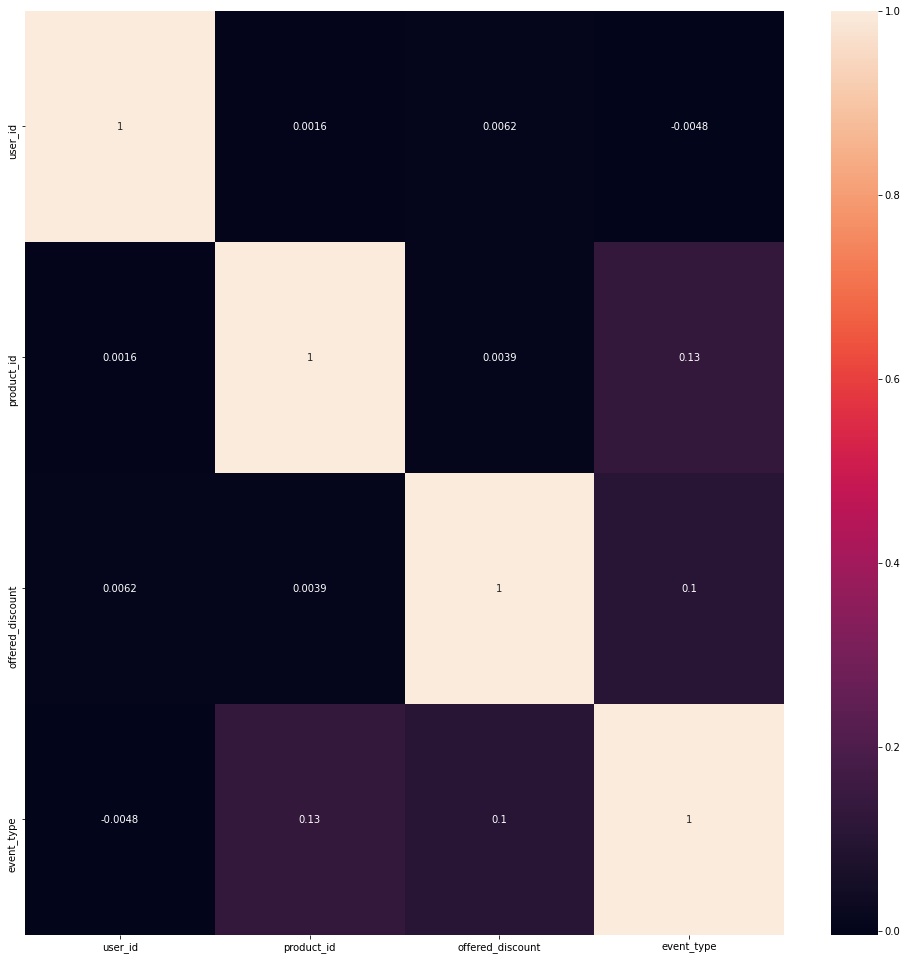

In [3]:
plt.figure(figsize=(17,17))

sns.heatmap(data[valuable_data].corr(),annot = True)

Jak widać nie ma prostego powiązania pomiędzy zakupem a resztą atrybutów - potrzebna będzie głębsza analiza oraz dodatkowe przekształcenia.

---

Wykres liczby zakupionych produktów zależnie od zaoferowanej zniżki

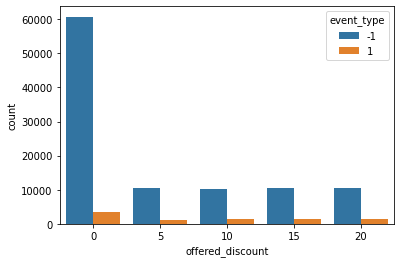

In [4]:
g = sns.countplot(x="offered_discount",hue="event_type",data=data)

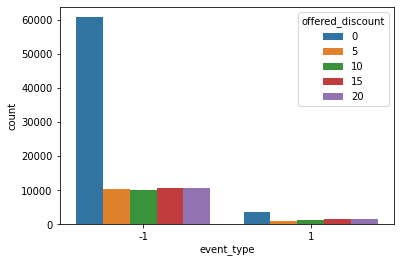

In [5]:
g2 = sns.countplot(x="event_type",hue="offered_discount",data=data)

---

Wykaz sesji zakończonych zakupem i tylko przeglądaniem (dla wszystkich użytkowników)

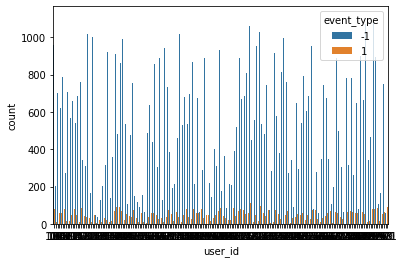

In [6]:
g3 = sns.countplot(x='user_id',hue='event_type',data=data)

---

Wykres liczby odwiedzin/zakupów w zależności od numeru ident. produktu

Możemy zauważyć, że w sklepie zakupione były tylko niektóre przedmioty, a większość była tylko przeglądana

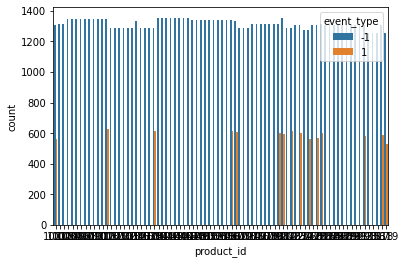

In [7]:
g4 = sns.countplot(x='product_id',hue='event_type',data=data)

---

Liczba zakupionych produktów w zależności od zaoferowanej zniżki

In [8]:
d1 = data[data.event_type == 1].groupby(['offered_discount']).count()['event_type']
d1

offered_discount
0     3601
5     1021
10    1321
15    1465
20    1463
Name: event_type, dtype: int64

In [9]:
d2 = data.groupby(['offered_discount']).count()['event_type']
d2

offered_discount
0     64331
5     11539
10    11460
15    12023
20    12042
Name: event_type, dtype: int64

In [10]:
d3 = d1/d2
d3

offered_discount
0     0.055976
5     0.088483
10    0.115271
15    0.121850
20    0.121491
Name: event_type, dtype: float64

Widzimy, że dla zniżek powyżej 5% ok 12% sesji, które miały taką zniżkę, zakończyła się zakupem

<AxesSubplot:title={'center':'buy to all'}, xlabel='offered_discount'>

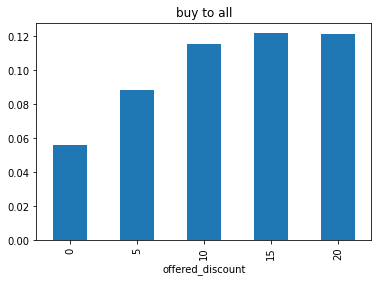

In [11]:
d3.plot(kind='bar',title='buy to all')

In [12]:
d4 = data[data.event_type == 1]
d4.head()

,timestamp,user_id,product_id,offered_discount,event_type
3,2021-02-27 22:25:40,102,1283,0,1
14,2021-02-18 15:58:06,102,1013,0,1
37,2021-03-26 19:19:50,102,1067,10,1
60,2021-02-14 00:54:47,102,1234,10,1
63,2021-03-15 21:29:57,102,1234,20,1


---

Wykres liczby zakupów w zależności od zaoferowanej zniżki (tylko dla kupionych produktów)

<AxesSubplot:xlabel='product_id', ylabel='count'>

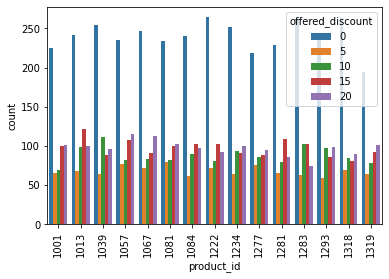

In [13]:
g_prod_disc = sns.countplot(x='product_id',hue='offered_discount',data=d4)
g_prod_disc.set_xticklabels(g_prod_disc.get_xticklabels(), rotation=90)
g_prod_disc

---

Wykres oferowanych zniżek dla produktów

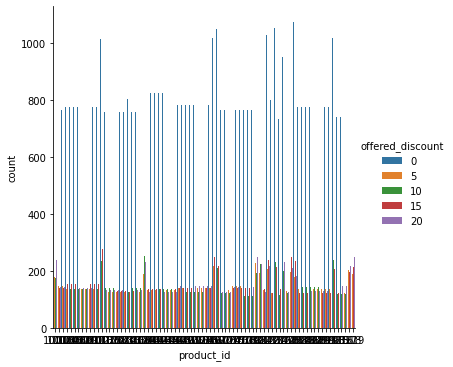

In [14]:
sns.catplot(data=data,x='product_id',hue='offered_discount',kind='count')

Rozkład jest równomierny pomiędzy produktami

---

# Przetwarzanie danych

## Uzupełnianie brakujących danych

In [15]:

clean_data = data
for i, d in clean_data.iterrows():
    if d.isnull().product_id and d.event_type == 1:
        clean_data.at[i,'product_id'] = data.at[i-1,'product_id']
    if d.isnull().product_id and clean_data.at[i+1,'event_type'] == 1:
        clean_data.at[i,'product_id'] = data.at[i+1,'product_id']
    if d.isnull().user_id:
        clean_data.at[i,'user_id'] = data[data.session_id == d.session_id]['user_id'].dropna().median()


Tam, gdzie możemy, uzupełniamy brakujące user_id znając session_id. Zauważamy też, że w ramach jednej sesji każdy zakup zawsze poprzedzony jest obejrzeniem danego produktu. W ten sposób uzupełniamy potencjalne braki

In [16]:
clean_data

,timestamp,user_id,product_id,offered_discount,event_type
0,2021-03-13 20:26:23,102,1276,0,-1
1,2021-03-13 20:30:41,102,1277,0,-1
2,2021-02-27 22:24:43,102,1283,0,-1
3,2021-02-27 22:25:40,102,1283,0,1
4,2021-02-18 15:32:43,102,1004,0,-1
...,...,...,...,...,...
111390,2021-03-05 13:47:04,301,1009,0,-1
111391,2021-03-05 13:49:10,301,1010,0,-1
111392,2021-03-05 13:53:10,301,1011,0,-1
111393,2021-03-05 13:55:37,301,1012,0,-1


---

Sortujemy dane ze względu na id użytkownika, dalej po id produktu, na samym końcu po stemplu czasowym. W ten sposób grupujemy dane - pojedyncza grupa zawiera pełny przebieg odwiedzin danego produktu przez użytkownika.

In [17]:
sorted_data = clean_data[valuable_data].dropna().sort_values(by = ['user_id','product_id','timestamp'])
sorted_data.head()

,timestamp,user_id,product_id,offered_discount,event_type
867,2021-01-01 22:02:41,102,1001,0,-1
118,2021-01-27 10:06:25,102,1001,0,-1
119,2021-01-27 10:09:07,102,1001,0,1
182,2021-02-03 09:00:26,102,1001,0,-1
183,2021-02-03 09:04:17,102,1001,0,1


---

Dzielimy posortowane dane na części: 1 użytkownik - 1 produkt, posortowane po czasie sesji

In [18]:
dic = [x for _, x in sorted_data.groupby(["user_id", "product_id"])] 


---

Wcześniejsze części dzielimy na podzbiory "od zakupu do zakupu"

---

Liczymy różnicę czasów w naszych podziałach, żeby wiedzieć, ile trwał czas, od kiedy użytkownik wszedł na stronę produktu do momentu, kiedy go kupił

In [19]:
split_dic = []
for d in dic:
    last = 0
    for i in range(len(d)):
        if d.iloc[i].event_type == 1:
            split_dic.append(d[last:i+1])
            last = i+1
    if last < len(d):
        split_dic.append(d[last:len(d)])

In [20]:
for d in split_dic:
    t1 = d['timestamp'].diff()
    d.timestamp = t1

/home/tisek/.local/lib/python3.8/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [21]:
split_dic[3]

,timestamp,user_id,product_id,offered_discount,event_type
156,NaT,102,1001,15,-1
157,0 days 00:00:41,102,1001,15,1


## Finalny zbiór danych

Na podstawie powyższych podziałów obliczamy liczbę wizyt, całkowity czas, maksymalną zaoferowaną zniżkę oraz czy klient finalnie kupił przedmiot

In [22]:
final_data = []
for d in split_dic:
    n_visits = len(d)
    d_time = d.sum().timestamp.total_seconds()
    max_disc = d.max().offered_discount
    curr_disc = d.tail(1).offered_discount.item()
    is_purchased = d.tail(1).event_type.item()
    final_data.append([d_time,n_visits,max_disc,curr_disc,is_purchased]) 

In [23]:
df = pd.DataFrame(final_data,columns=["d_time","n_visits","max_disc","curr_disc","is_purchased"])
df

,d_time,n_visits,max_disc,curr_disc,is_purchased
0,2203586.0,3,0,0,1
1,231.0,2,0,0,1
2,1615023.0,4,15,15,1
3,41.0,2,15,15,1
4,1694617.0,3,20,0,-1
...,...,...,...,...,...
22252,2166583.0,4,10,10,1
22253,1653398.0,2,0,0,-1
22254,4114156.0,4,0,0,1
22255,1131925.0,3,15,15,1


## Filtracja danych
Odrzucamy dane, które mają mają tylko jedno wejście z kilku powodów:  
1. Pierwsze wejście nie powinno być od razu nagradzane zniżką  
2. Niektóre rekordy mają zerowe czasy trwania, co mogłoby sugerować duże zdecydowanie, jednak jeśli produkt został zakupiony, zarejestrowane muszą zostać co najmniej 2 wejścia  
3. Mogą być wynikiem brakujących danych, których nie udało nam się odzyskać

In [24]:
df = df[df.n_visits > 1]
len(df)

20348

In [25]:
df.to_json(data_folder_name+'/final.json',orient="records",lines=True)

---

Mapa korelacji nowego zestawu danych

<AxesSubplot:>

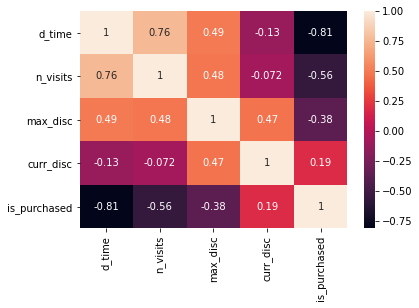

In [26]:
sns.heatmap(df.corr(),annot = True)

Widoczna jest silna korelacja pomiędzy zakupem i czasem oraz aktualną zniżką. Trochę gorzej, choć jednak wciąż znaczący wpływ ma liczba wizyt, zaś najgorzej wypada maksymalna zaoferowana do tej pory zniżka - zostawiamy ją jednak do dalszej analizy z powodu jej korelacji z obecną zniżką

---

Dodatkowa kolumna wizyt na minutę agregująca czas i wizyty oraz jednocześnie ograniczająca mocno wielkość danych wejściowych

In [27]:
visits_per_minute = df.n_visits / df.d_time * 60
df2 = df.copy(True)
df2.insert(2,"visits_per_minute",visits_per_minute,True) 

In [28]:
df2

,d_time,n_visits,visits_per_minute,max_disc,curr_disc,is_purchased
0,2203586.0,3,0.000082,0,0,1
1,231.0,2,0.519481,0,0,1
2,1615023.0,4,0.000149,15,15,1
3,41.0,2,2.926829,15,15,1
4,1694617.0,3,0.000106,20,0,-1
...,...,...,...,...,...,...
22251,11813.0,3,0.015237,20,20,1
22252,2166583.0,4,0.000111,10,10,1
22253,1653398.0,2,0.000073,0,0,-1
22254,4114156.0,4,0.000058,0,0,1


Jak widać ona również jest dość silnie skorelowana z zakupem 

<AxesSubplot:>

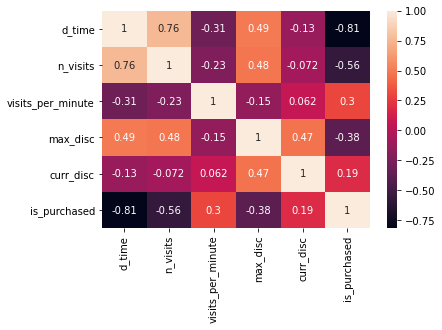

In [29]:
df2.to_json(data_folder_name+'/final_vpm.json',orient="records",lines=True)
sns.heatmap(df2.corr(),annot = True)

## Normalizacja danych
Normalizacja czasu metodą min-max

In [30]:
normal_t = df['d_time']
normalized_df = df.copy(True)
normalized_df.d_time = (normal_t-normal_t.min())/(normal_t.max()-normal_t.min())
df2.d_time = normalized_df.d_time

---

Wykres zależności czasu przeglądania produktu i stanu zakończenia sesji, dla znormalizowanego czasu

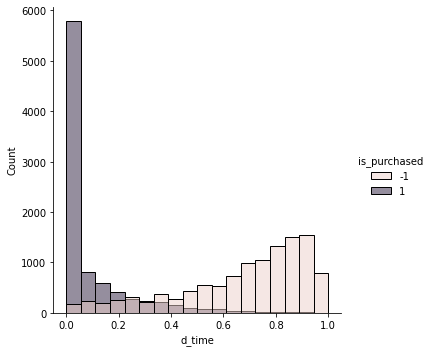

In [31]:
g_n1 = sns.displot(data = normalized_df,x='d_time',hue="is_purchased")

---

Zapis znormalizowanych danych do pliku

In [32]:
df2.to_json(data_folder_name+'/normal_vpm.json',orient="records",lines=True)
normalized_df.to_json(data_folder_name+'/normal_final.json',orient="records",lines=True)

## Założenia dotyczące wyników modelu

Aby nasz model był lepszy od naiwnego rozwiązania wybierania zawsze większościowej opcji musimy osiągnąć poprawność co najmniej 57%

In [33]:
bought = len(normalized_df[normalized_df.is_purchased == 1])
notbought = len(normalized_df[normalized_df.is_purchased != 1])
if bought >= notbought:
    print("bought")
else:
    print("notbought")
max(bought,notbought)/len(normalized_df)

notbought


0.5640357774719874